In [ ]:
#|hide
#|default_exp ner_pytorch

# NER with PyTorch
(follows: )
Use DL (neural network) for sequence labelling tasks: POS tagging or NER.

We will use the same, Dutch, datasets from NLTK we used in the previous notebook:

In [ ]:
import nltk

train_sents = list(nltk.corpus.conll2002.iob_sents('ned.train'))
dev_sents = list(nltk.corpus.conll2002.iob_sents('ned.testa'))
test_sents = list(nltk.corpus.conll2002.iob_sents('ned.testb'))

train_sents[:3]

[[('De', 'Art', 'O'),
  ('tekst', 'N', 'O'),
  ('van', 'Prep', 'O'),
  ('het', 'Art', 'O'),
  ('arrest', 'N', 'O'),
  ('is', 'V', 'O'),
  ('nog', 'Adv', 'O'),
  ('niet', 'Adv', 'O'),
  ('schriftelijk', 'Adj', 'O'),
  ('beschikbaar', 'Adj', 'O'),
  ('maar', 'Conj', 'O'),
  ('het', 'Art', 'O'),
  ('bericht', 'N', 'O'),
  ('werd', 'V', 'O'),
  ('alvast', 'Adv', 'O'),
  ('bekendgemaakt', 'V', 'O'),
  ('door', 'Prep', 'O'),
  ('een', 'Art', 'O'),
  ('communicatiebureau', 'N', 'O'),
  ('dat', 'Conj', 'O'),
  ('Floralux', 'N', 'B-ORG'),
  ('inhuurde', 'V', 'O'),
  ('.', 'Punc', 'O')],
 [('In', 'Prep', 'O'),
  ("'81", 'Num', 'O'),
  ('regulariseert', 'V', 'O'),
  ('de', 'Art', 'O'),
  ('toenmalige', 'Adj', 'O'),
  ('Vlaamse', 'Adj', 'B-MISC'),
  ('regering', 'N', 'O'),
  ('de', 'Art', 'O'),
  ('toestand', 'N', 'O'),
  ('met', 'Prep', 'O'),
  ('een', 'Art', 'O'),
  ('BPA', 'N', 'B-MISC'),
  ('dat', 'Pron', 'O'),
  ('het', 'Art', 'O'),
  ('bedrijf', 'N', 'O'),
  ('op', 'Prep', 'O'),
  ('eigen', 

Next, we have to pre-process the data. We can use `torchtext` for this. It is a Python library for pre-processing of natural language. We want our data to be a dataset that consists of examples.

Each example has two fields: A text filed and a label field. Both consist of sequential information: Tokens and labels.

In [ ]:
%pip install -U torchtext==0.8.1 # Also installed torch-1.7.1, which meant uninstalling torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.8/776.8 MB 6.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from torchtext.data import Example
from torchtext.data import Field, Dataset

text_field = Field(sequential=True, tokenize=lambda x:x, include_lengths=True)
label_field = Field(sequential=True, tokenize=lambda x:x, is_target=True)

def read_data(sentences):
  examples = []
  fields = {'sentence_labels': ('labels', label_field),
            'sentence_tokens': ('text', text_field)}

  for sentence in sentences:
    tokens = [t[0] for t in sentence]
    labels = [t[2] for t in sentence]

    e = Example.fromdict({"sentence_labels": labels, "sentence_tokens": tokens},
                          fields=fields)
    examples.append(e)
  return Dataset(examples, fields=[('labels', label_field), ('text', text_field)])

train_data = read_data(train_sents)
dev_data = read_data(dev_sents)
test_data = read_data(test_sents)

# Get some grip on what is being done
print(train_data.fields)
print(train_data[0].text)
print(train_data[0].labels)

print("Train:", len(train_data))
print("Dev:", len(dev_data))
print("Test:", len(test_data))

{'labels': <torchtext.data.field.Field object>, 'text': <torchtext.data.field.Field object>}
['De', 'tekst', 'van', 'het', 'arrest', 'is', 'nog', 'niet', 'schriftelijk', 'beschikbaar', 'maar', 'het', 'bericht', 'werd', 'alvast', 'bekendgemaakt', 'door', 'een', 'communicatiebureau', 'dat', 'Floralux', 'inhuurde', '.']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ORG', 'O', 'O']
Train: 15806
Dev: 2895
Test: 5195


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/example.py:52: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


Then, we build a vocabulary for both fields. The vocabulary will allow us to map every word and label to their index. One index is kept for unknown words, another for padding.

In [ ]:
VOCAB_SIZE = 20_000

text_field.build_vocab(train_data, max_size=VOCAB_SIZE)
label_field.build_vocab(train_data)

## Training

In [ ]:
import torch

device='cpu'
print(device)

cpu


`BucketIterator` takes care of a lot of details for our training runs:

- creates batches of similar length examples in the data
- maps the words and labels to the correct indices in their vocabularies
- pads the sentences in order to have sentences of the same length (using minimal padding; see first bullet)

In [ ]:
from torchtext.data import BucketIterator

BATCH_SIZE = 32
train_iter = BucketIterator(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, sort_key=lambda x: len(x.text), sort_within_batch=True)
dev_iter = BucketIterator(dataset=dev_data, batch_size=BATCH_SIZE, shuffle=True, sort_key=lambda x: len(x.text), sort_within_batch=True)
test_iter = BucketIterator(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, sort_key=lambda x: len(x.text), sort_within_batch=True)

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/iterator.py:48: UserWarning: BucketIterator class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


## Pre-trained embeddings

Pre-trained embeddings are useful to improve the performance of a model, especially if there is little training data. We use "meaning" from a larger dataset to sharpen our model: Better generalize between semantically related words.

For this we use **FastText** embeddings:

- download a `vec` file with the embeddings that we use to initialize our embedding matrix
- we create a matrix filled with zeros of which the number of rows == the number of words in our vocabulary; the number of cols == the number of FasText vectors (300)
- we must be sure that the FastText embedding for a particular word is in the correct row: The row whose index corresponds to the index of the word in the vocabulary.

In [ ]:
import random
import os
import numpy as np

EMBEDDING_PATH = os.path.join(os.path.expanduser('~'), "Documents/data/nlp/cc.nl.300.vec")

def load_embeddings(path):
  """Load the FastText embeddings from the NL embeddings file."""
  print('Loading the pre-trained embeddings')

  embeddings = {}
  with open(path) as i:
    for line in i:
      if len(line) > 2:
        line = line.strip().split()
        word = line[0]
        embedding = np.array(line[1:])
        embeddings[word] = embedding
  return embeddings

def initialize_embeddings(embeddings, vocabulary):
  """Use the pre-trained embeddings to initialize an embedding matrix."""
  print('Initializing embedding matrix')
  embedding_size = len(embeddings['.'])
  embedding_matrix = np.zeros((len(vocabulary), embedding_size), dtype=np.float32)

  for idx, word in enumerate(vocabulary.itos):
    if word in embeddings:
      embedding_matrix[idx,:] = embeddings[word]

  return embedding_matrix

embeddings = load_embeddings(EMBEDDING_PATH)
embedding_matrix = initialize_embeddings(embeddings, text_field.vocab)
embedding_matrix = torch.from_numpy(embedding_matrix).to(device)

Loading the pre-trained embeddings
Initializing embedding matrix


In [ ]:
embedding_matrix[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

## Caveat

Using Python 3.9 with somewhat older PyTorch and torchtext libraries on GPU caused Jupyter Kernel crash due to incompatible GPU specs. Updated to newest PyTorch & torchtext for GPU specs did crash the Notebook environment.

Then ran the code on Python 3.8. Explicitely setting torchtext to 0.81 and torch to 1.17 and running on the CPU. Seem stable.

I do not think we will need to build our own CNN's. First of all, because some of the software we are working with already has this capacity build in (spaCy: Retraining NER entities), but, more importantly, we concentrate on **supervised ML** in well described (smaller) doamins instead of all out **deep learning**.

If we were to dive in DL we must make sure that all these layers are stable over a longer period.

## Create the BiLSTM model

The BiLSTM model consists of 4 layers:

1. An embedding layer that maps one-hot vectors to dense word embeddings (pre-trained or trained from scratch);
2. A bi-directional LSTM layer that reads text b2f and f2b. For each word 2 output vectors are produced `hidden_dim` that are concatenated in a vector `2*hidden_dim`;
3. A dropout layer that helps to prevent overfitting by dropping a certain percentage of the items in the LSTM output;
4. A dense layer that projects the LSTM output to an output vector with a dimensionality == number of labels.

In [ ]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class BiLSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, output_size, embeddings=None):
        super(BiLSTMTagger, self).__init__()
        
        # 1. Embedding Layer
        if embeddings is None:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        else:
            self.embeddings = nn.Embedding.from_pretrained(embeddings)
        
        # 2. LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, bidirectional=True, num_layers=1)
        
        # 3. Optional dropout layer
        self.dropout_layer = nn.Dropout(p=0.5)

        # 4. Dense Layer
        self.hidden2tag = nn.Linear(2*hidden_dim, output_size)
        
    def forward(self, batch_text, batch_lengths):

        embeddings = self.embeddings(batch_text)
        
        packed_seqs = pack_padded_sequence(embeddings, batch_lengths)
        lstm_output, _ = self.lstm(packed_seqs)
        lstm_output, _ = pad_packed_sequence(lstm_output)
        lstm_output = self.dropout_layer(lstm_output)
        
        logits = self.hidden2tag(lstm_output)
        return logits


## Training

Now that we have our model, we need to train it. For that we need to make a couple of decisions:

- we pick a loss function (aka `criterion`) to quantify how far the model predictions are from the correct output. In the context of NER this often is `CrossEntropyLoss`;
- we need to choose an optimizer. In NLP: Adam optimizer (SGD variation).

Then the actual training starts. This happens in several epochs. During each epoch, we show all of the training data to the network, in the batches produced by the BucketIterators we created above. Before we show the model a new batch, we set the gradients of the model to zero to avoid accumulating gradients across batches. Then we let the model make its predictions for the batch. We do this by taking the output, and finding out what label received the highest score, using the torch.max method. We then compute the loss with respect to the correct labels. loss.backward() then computes the gradients for all model parameters; optimizer.step() performs an optimization step.

When we have shown all the training data in an epoch, we perform the precision, recall and F-score on the training data and development data. Note that we compute the loss for the development data, but we do not optimize the model with it. Whenever the F-score on the development data is better than before, we save the model. If the F-score is lower than the minimum F-score we've seen in the past few epochs (we call this number the patience), we stop training.

In [ ]:
import torch.optim as optim
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import precision_recall_fscore_support, classification_report


def remove_predictions_for_masked_items(predicted_labels, correct_labels): 

    predicted_labels_without_mask = []
    correct_labels_without_mask = []
        
    for p, c in zip(predicted_labels, correct_labels):
        if c > 1:
            predicted_labels_without_mask.append(p)
            correct_labels_without_mask.append(c)
            
    return predicted_labels_without_mask, correct_labels_without_mask


def train(model, train_iter, dev_iter, batch_size, max_epochs, num_batches, patience, output_path):
    criterion = nn.CrossEntropyLoss(ignore_index=1)  # we mask the <pad> labels
    optimizer = optim.Adam(model.parameters())

    train_f_score_history = []
    dev_f_score_history = []
    no_improvement = 0
    for epoch in range(max_epochs):

        total_loss = 0
        predictions, correct = [], []
        for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()
            
            text_length, cur_batch_size = batch.text[0].shape
            
            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size*text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size*text_length)
            
            loss = criterion(pred, gold)
            
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

            _, pred_indices = torch.max(pred, 1)
            
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        train_scores = precision_recall_fscore_support(correct, predictions, average="micro")
        train_f_score_history.append(train_scores[2])
            
        print("Total training loss:", total_loss)
        print("Training performance:", train_scores)
        
        total_loss = 0
        predictions, correct = [], []
        for batch in dev_iter:

            text_length, cur_batch_size = batch.text[0].shape

            pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
            gold = batch.labels.to(device).view(cur_batch_size * text_length)
            loss = criterion(pred, gold)
            total_loss += loss.item()

            _, pred_indices = torch.max(pred, 1)
            predicted_labels = list(pred_indices.cpu().numpy())
            correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())
            
            predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                                   correct_labels)
            
            predictions += predicted_labels
            correct += correct_labels

        dev_scores = precision_recall_fscore_support(correct, predictions, average="micro")
            
        print("Total development loss:", total_loss)
        print("Development performance:", dev_scores)
        
        dev_f = dev_scores[2]
        if len(dev_f_score_history) > patience and dev_f < max(dev_f_score_history):
            no_improvement += 1

        elif len(dev_f_score_history) == 0 or dev_f > max(dev_f_score_history):
            print("Saving model.")
            torch.save(model, output_path)
            no_improvement = 0
            
        if no_improvement > patience:
            print("Development F-score does not improve anymore. Stop training.")
            dev_f_score_history.append(dev_f)
            break
            
        dev_f_score_history.append(dev_f)
        
    return train_f_score_history, dev_f_score_history

Let's prepare to test the model, taking the same steps as above:

- get the predictions;
- remove the masked items;
- print a classification report.

In [ ]:
def test(model, test_iter, batch_size, labels, target_names): 
    
    total_loss = 0
    predictions, correct = [], []
    for batch in test_iter:

        text_length, cur_batch_size = batch.text[0].shape

        pred = model(batch.text[0].to(device), batch.text[1].to(device)).view(cur_batch_size * text_length, NUM_CLASSES)
        gold = batch.labels.to(device).view(cur_batch_size * text_length)

        _, pred_indices = torch.max(pred, 1)
        predicted_labels = list(pred_indices.cpu().numpy())
        correct_labels = list(batch.labels.view(cur_batch_size*text_length).numpy())

        predicted_labels, correct_labels = remove_predictions_for_masked_items(predicted_labels, 
                                                                               correct_labels)

        predictions += predicted_labels
        correct += correct_labels
    
    print(classification_report(correct, predictions, labels=labels, target_names=target_names))

After all these steps, we can start to actually train the model:

- set embedding dimension to 300 (FastText dimensionality);
- pick a hidden dimensionality for each component of the BiLSTM (outputs 512-dim vectors);
- the number of classes (== length of the vocabulary of the label field) will become the dimesionality of the output layer;
- compute the number of batches in an epoch in order to show a progress bar.

In [ ]:
import math

EMBEDDING_DIM = 300
HIDDEN_DIM = 256
NUM_CLASSES = len(label_field.vocab)
MAX_EPOCHS = 50
PATIENCE = 3
OUTPUT_PATH = "/tmp/bilstmtagger"
num_batches = math.ceil(len(train_data) / BATCH_SIZE)

tagger = BiLSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE+2, NUM_CLASSES, embeddings=embedding_matrix)  

train_f, dev_f = train(tagger.to(device), train_iter, dev_iter, BATCH_SIZE, MAX_EPOCHS, 
                       num_batches, PATIENCE, OUTPUT_PATH)

/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 0:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 226.21551628410816
Training performance: (0.922321904423521, 0.922321904423521, 0.922321904423521, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 25.44461453706026
Development performance: (0.9280919149839467, 0.9280919149839467, 0.9280919149839467, None)
Saving model.


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 1:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 73.94669454917312
Training performance: (0.9578127158958568, 0.9578127158958568, 0.9578127158958567, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 20.331317596137524
Development performance: (0.9359195478546979, 0.9359195478546979, 0.9359195478546979, None)
Saving model.


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 2:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 52.222703427542
Training performance: (0.9672282426323997, 0.9672282426323997, 0.9672282426323997, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 19.240757752908394
Development performance: (0.9393955475362857, 0.9393955475362857, 0.9393955475362857, None)
Saving model.


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 3:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 43.15425827750005
Training performance: (0.9718965279011469, 0.9718965279011469, 0.9718965279011469, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 17.042858469765633
Development performance: (0.9435879746331626, 0.9435879746331626, 0.9435879746331626, None)
Saving model.


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 4:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 36.53407029993832
Training performance: (0.9752817749353546, 0.9752817749353546, 0.9752817749353546, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 16.781842106487602
Development performance: (0.9441717303048797, 0.9441717303048797, 0.9441717303048797, None)
Saving model.


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 5:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 31.784735803026706
Training performance: (0.9778971990288388, 0.9778971990288388, 0.9778971990288388, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 15.139236290880945
Development performance: (0.9482049513094701, 0.9482049513094701, 0.9482049513094701, None)
Saving model.


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 6:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 28.689999663620256
Training performance: (0.9792394544126646, 0.9792394544126646, 0.9792394544126646, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 16.298973719996866
Development performance: (0.9463740812481758, 0.9463740812481758, 0.9463740812481758, None)


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 7:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 25.47622849655454
Training performance: (0.9813219241625708, 0.9813219241625708, 0.9813219241625708, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 16.30899855613825
Development performance: (0.9471966460583225, 0.9471966460583225, 0.9471966460583225, None)


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 8:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 22.8097926521732
Training performance: (0.9825062671482995, 0.9825062671482995, 0.9825062671482995, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 15.224460061523132
Development performance: (0.9477804017300395, 0.9477804017300395, 0.9477804017300395, None)


/tmp/ipykernel_13013/4049597506.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm(train_iter, total=num_batches, desc=f"Epoch {epoch}"):


Epoch 9:   0%|          | 0/494 [00:00<?, ?it/s]

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total training loss: 20.798322341113817
Training performance: (0.9842926511517736, 0.9842926511517736, 0.9842926511517736, None)


/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


Total development loss: 16.804522761842236
Development performance: (0.9480988139146125, 0.9480988139146125, 0.9480988139146125, None)
Development F-score does not improve anymore. Stop training.


F-score does not **improve** anymore. Let's plot the F-scores for our training and development sets. We aim for reaching an optimal F-score on the development data:

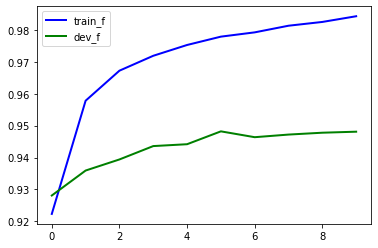

In [ ]:
%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd

# Data
df = pd.DataFrame({'epochs': range(0,len(train_f)), 
                  'train_f': train_f, 
                   'dev_f': dev_f})
 
# multiple line plot
plt.plot('epochs', 'train_f', data=df, color='blue', linewidth=2)
plt.plot('epochs', 'dev_f', data=df, color='green', linewidth=2)
plt.legend()
plt.show()

Before we test our model on the test data, we have to run its eval() method. This will put the model in eval mode, and deactivate dropout layers and other functionality that is only useful in training:

In [ ]:
tagger = torch.load(OUTPUT_PATH)
tagger.eval()

BiLSTMTagger(
  (embeddings): Embedding(20002, 300)
  (lstm): LSTM(300, 256, bidirectional=True)
  (dropout_layer): Dropout(p=0.5, inplace=False)
  (hidden2tag): Linear(in_features=512, out_features=11, bias=True)
)

Finally we are ready to test the model. It's performance is lower than our CRF model (04_ner_crf.ipynb). It is not only the code that grew compared to the earlier CRF model, but also the extra work we still have to do:

- make the architecture of the network more complex
- optimize the hyperparameters
- throw a lot more data at the model

## Testing our model

In [ ]:
labels = label_field.vocab.itos[3:]
labels = sorted(labels, key=lambda x: x.split("-")[-1])
label_idxs = [label_field.vocab.stoi[l] for l in labels]

test(tagger, test_iter, BATCH_SIZE, labels = label_idxs, target_names = labels)

/home/peter/anaconda3/envs/py38/lib/python3.8/site-packages/torchtext/data/batch.py:23: UserWarning: Batch class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)


              precision    recall  f1-score   support

       B-LOC       0.89      0.63      0.73       774
       I-LOC       0.53      0.39      0.45        49
      B-MISC       0.90      0.44      0.59      1187
      I-MISC       0.70      0.18      0.29       410
       B-ORG       0.78      0.52      0.62       882
       I-ORG       0.71      0.57      0.64       551
       B-PER       0.85      0.69      0.76      1098
       I-PER       0.95      0.68      0.79       807

   micro avg       0.84      0.55      0.67      5758
   macro avg       0.79      0.51      0.61      5758
weighted avg       0.84      0.55      0.66      5758



## Conclusion

In this notebook we've trained a simple bidirectional LSTM for named entity recognition. Far from achieving state-of-the-art performance, our aim was to understand how neural networks can be implemented and trained in PyTorch. To improve our performance, one of the things that is typically done is to add an additional CRF layer to the neural network. This layer helps us optimize the complete label sequence, and not the labels individually. We leave that for future work.